In [0]:
# importing frameworks/packages that are required for the model to run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


# **Data Pre-processing**

In [0]:
# Reading the train, test and RUL files (FD001 dataset)

df_train = pd.read_csv("https://raw.githubusercontent.com/sivaji1233/09_turbofan_rul/master/data/train_FD001.txt", sep = ' ', header = None)
df_test = pd.read_csv("https://raw.githubusercontent.com/sivaji1233/09_turbofan_rul/master/data/test_FD001.txt", sep = ' ', header = None)
df_RUL = pd.read_csv("https://raw.githubusercontent.com/sivaji1233/09_turbofan_rul/master/data/RUL_FD001.txt", header = None)


In [0]:
# Cleaning the data (2 extra columns were added due to white space, deleting those and adding the column names)
# for easy and clear understanding I'll work on set1 out of 4 and report the results for other sets in the report)

col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']

df_train = df_train[list(range(26))]
df_train.columns = col_list

df_test = df_test[list(range(26))]
df_test.columns = col_list

In [4]:
# Reading first 5 rows of the train dataset

df_train.head()

,unit,time,os_1,os_2,os_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# Making sure no missing values are there in the data

df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
unit     20631 non-null int64
time     20631 non-null int64
os_1     20631 non-null float64
os_2     20631 non-null float64
os_3     20631 non-null float64
sm_1     20631 non-null float64
sm_2     20631 non-null float64
sm_3     20631 non-null float64
sm_4     20631 non-null float64
sm_5     20631 non-null float64
sm_6     20631 non-null float64
sm_7     20631 non-null float64
sm_8     20631 non-null float64
sm_9     20631 non-null float64
sm_10    20631 non-null float64
sm_11    20631 non-null float64
sm_12    20631 non-null float64
sm_13    20631 non-null float64
sm_14    20631 non-null float64
sm_15    20631 non-null float64
sm_16    20631 non-null float64
sm_17    20631 non-null int64
sm_18    20631 non-null int64
sm_19    20631 non-null float64
sm_20    20631 non-null float64
sm_21    20631 non-null float64
dtypes: float64(22), int64(4)
memory usage: 4.1 MB


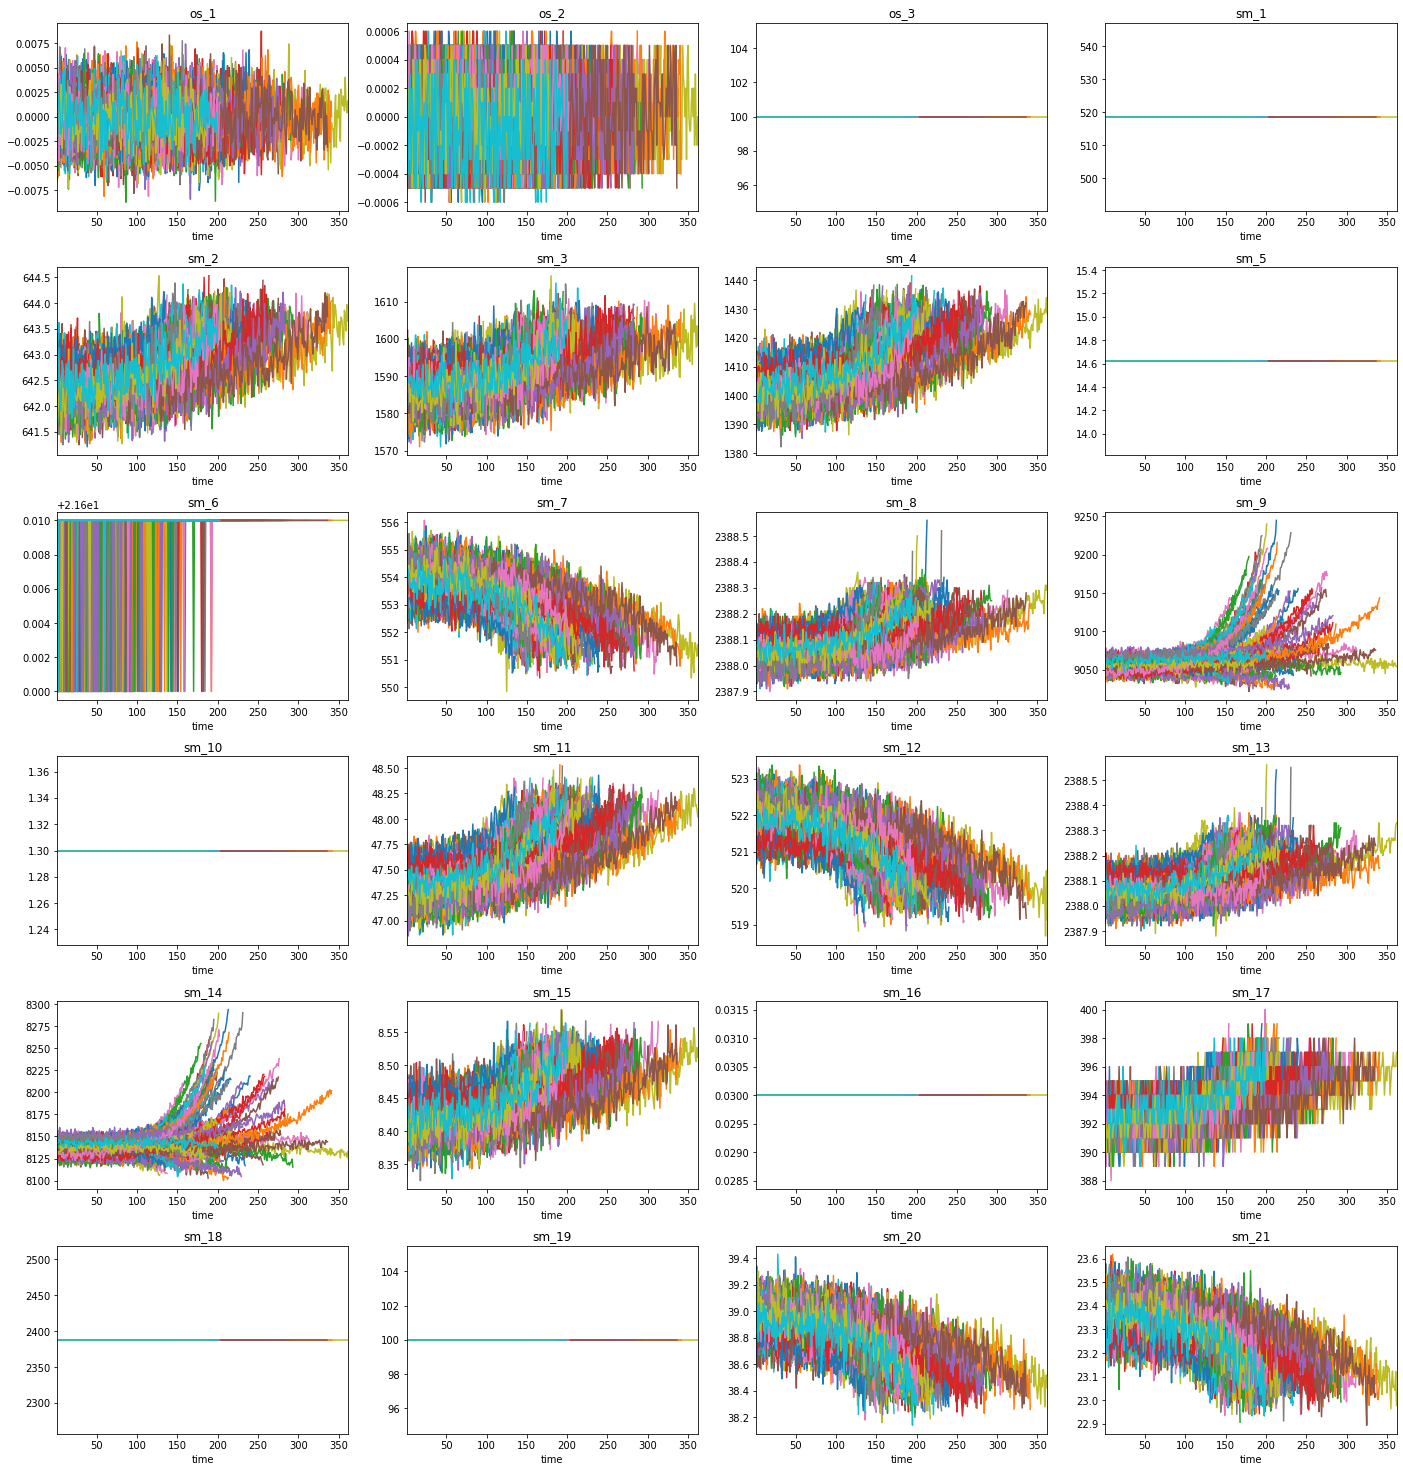

In [6]:
# Plotting the sensor measurements, to see significant changing trend from healty state and failure.

fig, ax = plt.subplots(ncols=4, nrows =6, figsize=(24, 20))
ax = ax.ravel()
for i, item in enumerate(col_list[2:]):
  df_train.groupby('unit').plot(kind='line', x = "time", y = item, ax=ax[i])
  ax[i].get_legend().remove()
  ax[i].title.set_text(item)
plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.3, wspace = 0.2)
plt.show()

In [7]:
# From the above figure it is clearly evident that columns ['os3', 'sm1', 'sm5', 'sm10', 'sm16', 'sm18', 'sm19'] are not contributing to significant change from healthy life to failure life, hence omitting the values for further model development

new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
df_train = df_train[new_col_list]
df_train['cycle'] = df_train['time']
df_test = df_test[new_col_list]
df_test['cycle'] = df_test['time']
df_train.head()

,unit,time,os_1,os_2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,cycle
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,1
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,2
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,3
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,4
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,5


In [8]:
# Scaling the values

scale_col_list = new_col_list[2:] + ['cycle']
df_train[scale_col_list] = minmax_scale(df_train[scale_col_list])
df_test[scale_col_list] = minmax_scale(df_test[scale_col_list])

df_train.head()

,unit,time,os_1,os_2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,cycle
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.00000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.00277
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.00554
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.00831
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.01108


# **Approach: Using GRU network**

First the input sequences that are to be fed to the model, shall be of same size and contains 17 features of 'os's and 'sm's data. Inorder to find the seq lenght I'm assuming the size of the least sequence of my test data set.

In [9]:
# Minimum length of the sequence in test dataset

seq_selected = min(df_test.groupby('unit').max()['time'])
print("The mimium length of the sequence in test dataset is", seq_selected)

The mimium length of the sequence in test dataset is 31


## Input train sequences:

The train sequences for input are prepared by using the seq_selected length. For every unit sequences of length seq_selected are selected from the start of the cycle and are stacked in the train dataset. Each sequence is in the dimension of [1 x seq_selected x 18]. This is done for every unit until the max cycle - seq_selected cycle.

In [10]:
# Preparation of inputs for training

max_list = list(df_train.groupby('unit').max()['time'])     # creating a list of max cycles in the training dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     # for converting the GPU supported tensors in case of using GPU

i = 0
X_train = Variable(torch.Tensor([]).float()).to(device)
for item in max_list:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  for j in range(item - seq_selected):
      zero_list = Variable(torch.Tensor(df_train.values[i+j:i+j+seq_selected, 2:]).float()).to(device)
      temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
  i += item
  X_train = torch.cat((X_train, temp_list), dim=0)

print("The shape of input data for training model, X_train is", X_train.shape)

The shape of input data for training model, X_train is torch.Size([17531, 31, 18])


In [11]:
# Preparation of labels for training

y_train = []
for item in max_list:
  y_train.extend(list(range(item-seq_selected))[::-1])
y_train = Variable(torch.Tensor(y_train).float()).to(device)
y_train = y_train.view(X_train.shape[0], 1)

print("The shape of labels data for training model, y_train is", y_train.shape)

The shape of labels data for training model, y_train is torch.Size([17531, 1])


In [0]:
# Model parameters

batch_size = 250
# learning_rate = 0.00001
num_epochs = 100
hidden_dim = 50
hidden_dim2 = 25

## **Model**

In [13]:
class lstm(nn.Module):
    def __init__(self, hidden_dim, hidden_dim2):
        super(lstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.lstm = nn.GRU(18, hidden_dim, dropout = 0.2, batch_first = True)
        self.lstm2 = nn.GRU(hidden_dim, hidden_dim2, dropout = 0.2, batch_first=True)
        self.linear = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

model = lstm(hidden_dim= hidden_dim, hidden_dim2=hidden_dim2).to(device)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters())
optimizer = torch.optim.RMSprop(model.parameters())

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## **Training**

epoch [1/100], loss:6246.5708
epoch [11/100], loss:2288.3811
epoch [21/100], loss:799.3394
epoch [31/100], loss:1034.7986
epoch [41/100], loss:855.4963
epoch [51/100], loss:577.7271
epoch [61/100], loss:338.7048
epoch [71/100], loss:434.1390
epoch [81/100], loss:210.2510
epoch [91/100], loss:138.6360


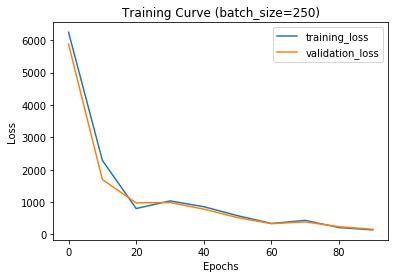

In [15]:
# training the model

train_loss = []
val_loss = []
epochs = []
for epoch in range(num_epochs):
  permutation = torch.randperm(X_train.size()[0])
  val_permutation = permutation[:X_train.size()[0]//3]
  train_permutation = permutation[X_train.size()[0]//3:]
  
  for i in range(0, len(train_permutation), batch_size):

    # Training model
    optimizer.zero_grad()
    indices = train_permutation[i:i+batch_size]
    batch_x = X_train[indices]
    out = model(batch_x)
    loss = criterion(out, y_train[indices])

    # Validation
    val_predict = model(X_train[val_permutation])
    val_loss_cal = criterion(val_predict, y_train[val_permutation])

    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    train_loss.append(loss.item())
    val_loss.append(val_loss_cal.item())
    epochs.append(epoch)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

plt.plot(epochs, train_loss, label = "training_loss")
plt.plot(epochs, val_loss, label = "validation_loss")
plt.title("Training Curve (batch_size={})".format(batch_size))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
torch.save(model.state_dict(), 'model_weights.pth')

## **Prediction**

In [16]:
# Preparing Test data

max_list_test = list(df_test.groupby('unit').max()['time'])

i = 0
X_test = Variable(torch.Tensor([]).float()).to(device)
for item in max_list_test:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  zero_list = Variable(torch.Tensor(df_test.values[i + item - seq_selected : i + item, 2:]).float()).to(device)
  temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
  i += item
  X_test = torch.cat((X_test, temp_list), dim=0)

print(X_test.shape)

torch.Size([100, 31, 18])


In [0]:
# Preparing test labels

y_test = df_RUL.values
y_test = Variable(torch.Tensor(y_test).float()).to(device)

In [18]:
# Predicting loss on the test dataset

y_pred = model(X_test)
test_loss = criterion(y_pred, y_test)

print("The loss on test data is", test_loss.item())

The loss on test data is 1600.0321044921875


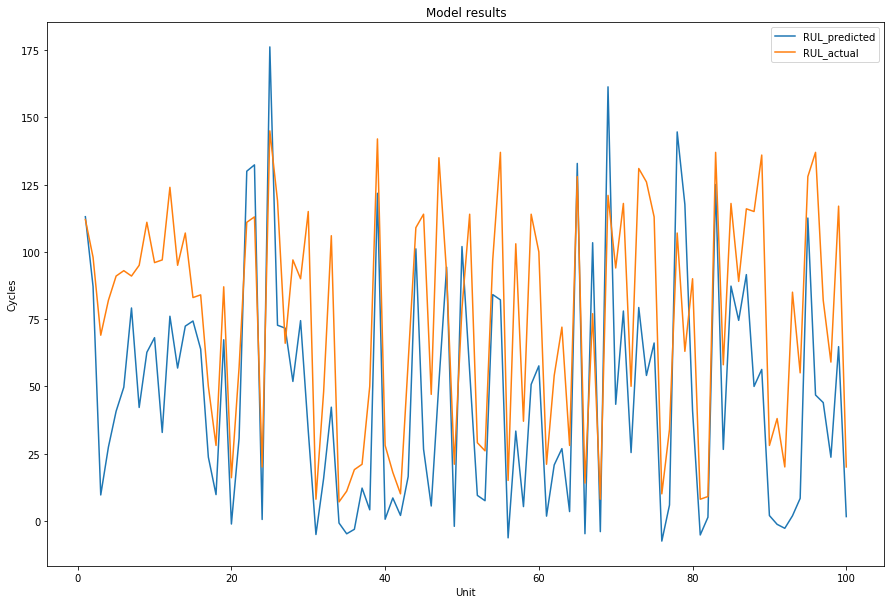

In [19]:
# Plotting predicted vs actual RULs

plt.figure(figsize=(15,10))
plt.plot(list(range(1,101)), y_pred.view(100).tolist(), label='RUL_predicted')
plt.plot(list(range(1,101)), y_test.view(100).tolist(), label="RUL_actual")
plt.title("Model results")
plt.xlabel("Unit")
plt.ylabel("Cycles")
plt.legend()
plt.show()

# **2.4 Conclusion**

Following are a few points that are concluded. 
1. Further fine-tuning of the hyperparameters and exploring various architectures are necessary for enhancing the performance of the model on test set. 
2. One of the reasons for high loss on test set is because of the less considered sequence length, increasing sequence length to 50 improved the performance, howerer 3 engine IDs don’t have cycles more than 50. 
3. Dealing with the noise, taking measures to reduce may also help the models performance.


In [0]:
pip freeze > requirements.txt